In [1]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [2]:
traj_path = Path('/Users/tonizeng/Desktop/ibd_trajectory_project/results/dual_encoder_model/latent_trajectories.pkl')
with open(traj_path, 'rb') as f:
    trajectories = pickle.load(f)

data_path = Path('/Users/tonizeng/Desktop/ibd_trajectory_project/data/processed/multimodal_unaligned_data.pkl')
with open(data_path, 'rb') as f:
    data = pickle.load(f)

patients = data['patients']
train_traj = trajectories['train']
val_traj = trajectories['val']

all_traj = {**train_traj, **val_traj}

print(f"Total patients for clustering: {len(all_traj)}")
print(f"CD: {sum(1 for t in all_traj.values() if t['diagnosis'] == 'CD')}")
print(f"UC: {sum(1 for t in all_traj.values() if t['diagnosis'] == 'UC')}")

Total patients for clustering: 85
CD: 41
UC: 22


## extract trajectory features

In [3]:
def compute_patient_trajectory_features(traj_data):
    """Extract comprehensive trajectory features for one patient."""
    timepoints = traj_data['timepoints']
    latent_traj = traj_data['latent_trajectory']
    
    if len(latent_traj) < 3:
        return None
    
    displacement = np.linalg.norm(latent_traj[-1] - latent_traj[0])
    
    step_vectors = np.diff(latent_traj, axis=0)
    step_lengths = np.linalg.norm(step_vectors, axis=1)
    path_length = np.sum(step_lengths)
    
    directionality = displacement / (path_length + 1e-6)
    
    time_diffs = np.diff(timepoints)
    velocities = step_lengths / (time_diffs + 1e-6)
    
    mean_velocity = np.mean(velocities)
    velocity_std = np.std(velocities)
    max_velocity = np.max(velocities)
    
    max_vel_idx = np.argmax(velocities)
    time_to_max_vel = timepoints[max_vel_idx] - timepoints[0]
    total_time = timepoints[-1] - timepoints[0]
    time_to_max_vel_norm = time_to_max_vel / (total_time + 1e-6)
    
    if len(step_vectors) > 1:
        step_vectors_norm = step_vectors / (np.linalg.norm(step_vectors, axis=1, keepdims=True) + 1e-6)
        
        dot_products = np.sum(step_vectors_norm[:-1] * step_vectors_norm[1:], axis=1)
        dot_products = np.clip(dot_products, -1, 1)
        
        angles = np.arccos(dot_products)
        mean_curvature = np.mean(angles)
        max_curvature = np.max(angles)
    else:
        mean_curvature = 0
        max_curvature = 0
    
    traj_range = np.ptp(latent_traj, axis=0)
    traj_volume = np.prod(traj_range)
    
    features = {
        'displacement': displacement,
        'path_length': path_length,
        'directionality': directionality,
        'mean_velocity': mean_velocity,
        'velocity_std': velocity_std,
        'max_velocity': max_velocity,
        'time_to_max_vel_norm': time_to_max_vel_norm,
        'mean_curvature': mean_curvature,
        'max_curvature': max_curvature,
        'traj_volume': traj_volume,
        'n_timepoints': len(timepoints),
        'total_time': total_time
    }
    
    return features

# Extract features for all patients
patient_features = {}

for patient_id, traj_data in all_traj.items():
    features = compute_patient_trajectory_features(traj_data)
    if features is not None:
        patient_features[patient_id] = {
            **features,
            'diagnosis': traj_data['diagnosis']
        }

print(f"\nExtracted features for {len(patient_features)} patients")

# Convert to DataFrame
feature_names = ['displacement', 'path_length', 'directionality', 
                'mean_velocity', 'velocity_std', 'max_velocity',
                'time_to_max_vel_norm', 'mean_curvature', 'max_curvature', 'traj_volume']

feature_matrix = []
patient_ids = []
diagnoses = []

for patient_id, features in patient_features.items():
    feature_matrix.append([features[name] for name in feature_names])
    patient_ids.append(patient_id)
    diagnoses.append(features['diagnosis'])

feature_df = pd.DataFrame(feature_matrix, columns=feature_names, index=patient_ids)
feature_df['diagnosis'] = diagnoses

print(f"\nFeature matrix shape: {feature_df.shape}")
print(f"\nFeature summary:")
print(feature_df[feature_names].describe())


Extracted features for 85 patients

Feature matrix shape: (85, 11)

Feature summary:
       displacement  path_length  directionality  mean_velocity  velocity_std  \
count  8.500000e+01    85.000000       85.000000      85.000000     85.000000   
mean   1.999437e+00    31.521626        0.145499       0.783822      0.762905   
std    2.049376e+00    31.773151        0.235091       0.798121      0.724179   
min    5.982601e-07     0.000048        0.004836       0.000001      0.000001   
25%    3.334824e-01     5.365254        0.037104       0.130441      0.121645   
50%    1.500929e+00    19.605032        0.061042       0.504702      0.649852   
75%    2.877258e+00    49.363694        0.115837       1.125725      1.199065   
max    1.256039e+01   129.404492        0.999999       3.701241      3.886938   

       max_velocity  time_to_max_vel_norm  mean_curvature  max_curvature  \
count     85.000000             85.000000       85.000000      85.000000   
mean       2.678327             

## feature processing

In [4]:
cd_features = feature_df[feature_df['diagnosis'] == 'CD'][feature_names].values
uc_features = feature_df[feature_df['diagnosis'] == 'UC'][feature_names].values

cd_ids = feature_df[feature_df['diagnosis'] == 'CD'].index.tolist()
uc_ids = feature_df[feature_df['diagnosis'] == 'UC'].index.tolist()

print(f"CD patients: {len(cd_features)}")
print(f"UC patients: {len(uc_features)}")

scaler_cd = StandardScaler()
scaler_uc = StandardScaler()

cd_features_scaled = scaler_cd.fit_transform(cd_features)
uc_features_scaled = scaler_uc.fit_transform(uc_features)

print("\nFeatures standardized (mean=0, std=1)")

CD patients: 41
UC patients: 22

Features standardized (mean=0, std=1)


## cluster optimization

In [5]:
def evaluate_clustering(X, k_range=(2, 6)):
    results = []
    
    for k in range(k_range[0], k_range[1] + 1):
        # K-means
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
        labels_km = kmeans.fit_predict(X)
        
        # GMM
        gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
        labels_gmm = gmm.fit_predict(X)
        
        # Metrics
        sil_km = silhouette_score(X, labels_km)
        db_km = davies_bouldin_score(X, labels_km)
        
        sil_gmm = silhouette_score(X, labels_gmm)
        db_gmm = davies_bouldin_score(X, labels_gmm)
        
        results.append({
            'k': k,
            'silhouette_kmeans': sil_km,
            'davies_bouldin_kmeans': db_km,
            'silhouette_gmm': sil_gmm,
            'davies_bouldin_gmm': db_gmm
        })
    
    return pd.DataFrame(results)

print("Evaluating CD clustering...")
cd_eval = evaluate_clustering(cd_features_scaled)
print(cd_eval)

print("\nEvaluating UC clustering...")
uc_eval = evaluate_clustering(uc_features_scaled)
print(uc_eval)

Evaluating CD clustering...
   k  silhouette_kmeans  davies_bouldin_kmeans  silhouette_gmm  \
0  2           0.311121               1.222601        0.281151   
1  3           0.360272               0.929450        0.235732   
2  4           0.325062               0.737442        0.295829   
3  5           0.295840               0.858306        0.243679   
4  6           0.267379               0.900892        0.269473   

   davies_bouldin_gmm  
0            1.268107  
1            1.267148  
2            1.031114  
3            1.085422  
4            1.076529  

Evaluating UC clustering...
   k  silhouette_kmeans  davies_bouldin_kmeans  silhouette_gmm  \
0  2           0.282551               1.243368        0.282551   
1  3           0.280827               0.879747        0.203584   
2  4           0.260226               0.945114        0.188031   
3  5           0.236123               0.842312        0.207387   
4  6           0.200419               0.839904        0.196729   

   da

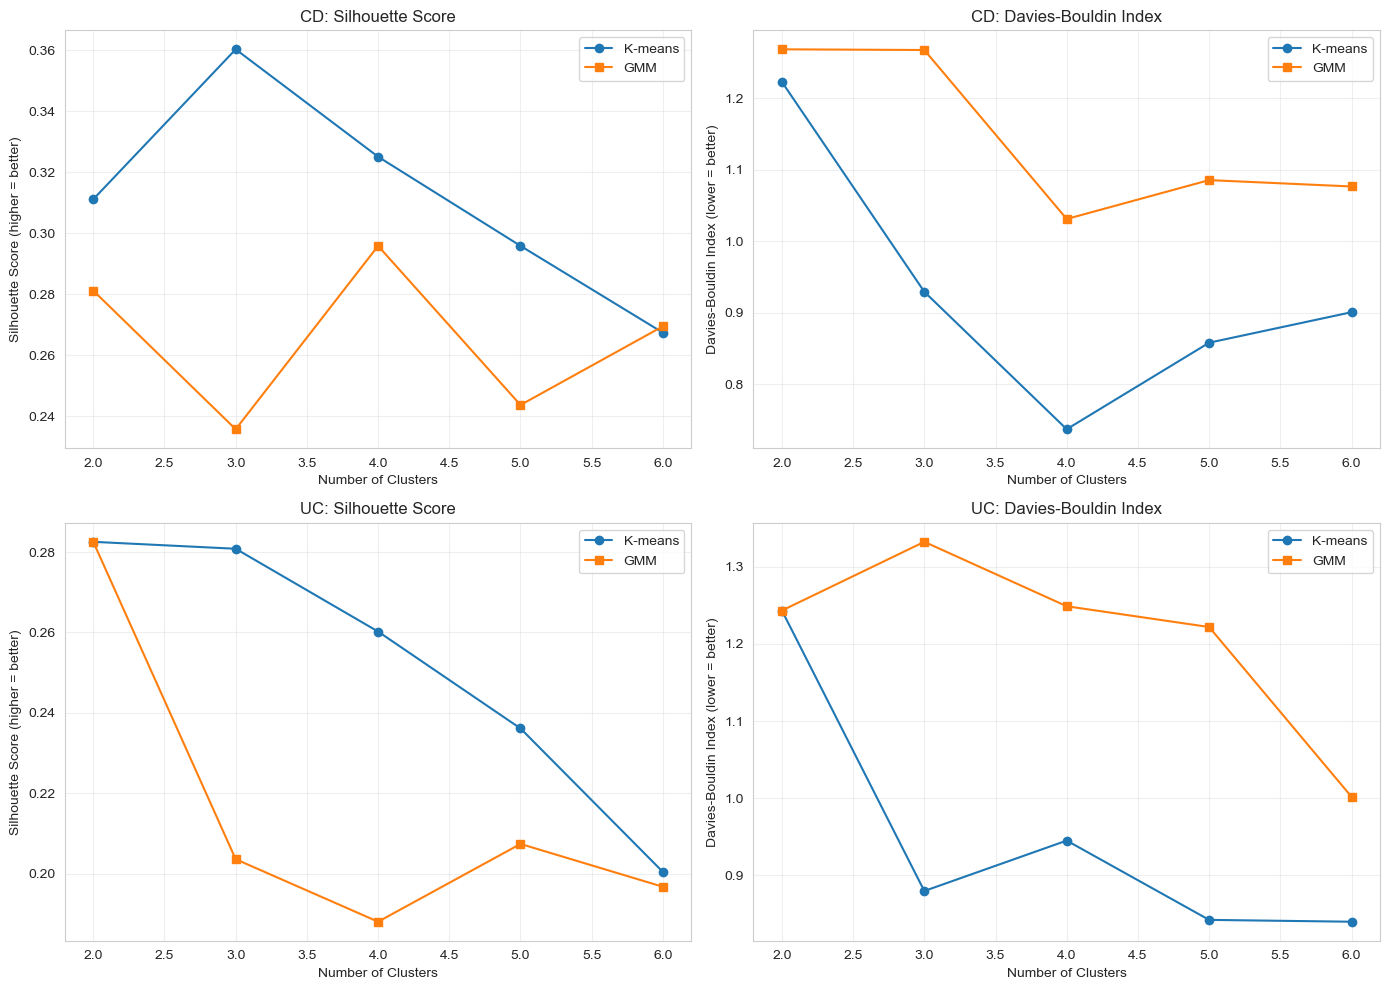

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# CD silhouette
axes[0, 0].plot(cd_eval['k'], cd_eval['silhouette_kmeans'], 'o-', label='K-means')
axes[0, 0].plot(cd_eval['k'], cd_eval['silhouette_gmm'], 's-', label='GMM')
axes[0, 0].set_xlabel('Number of Clusters')
axes[0, 0].set_ylabel('Silhouette Score (higher = better)')
axes[0, 0].set_title('CD: Silhouette Score')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# CD Davies-Bouldin
axes[0, 1].plot(cd_eval['k'], cd_eval['davies_bouldin_kmeans'], 'o-', label='K-means')
axes[0, 1].plot(cd_eval['k'], cd_eval['davies_bouldin_gmm'], 's-', label='GMM')
axes[0, 1].set_xlabel('Number of Clusters')
axes[0, 1].set_ylabel('Davies-Bouldin Index (lower = better)')
axes[0, 1].set_title('CD: Davies-Bouldin Index')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# UC silhouette
axes[1, 0].plot(uc_eval['k'], uc_eval['silhouette_kmeans'], 'o-', label='K-means')
axes[1, 0].plot(uc_eval['k'], uc_eval['silhouette_gmm'], 's-', label='GMM')
axes[1, 0].set_xlabel('Number of Clusters')
axes[1, 0].set_ylabel('Silhouette Score (higher = better)')
axes[1, 0].set_title('UC: Silhouette Score')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# UC Davies-Bouldin
axes[1, 1].plot(uc_eval['k'], uc_eval['davies_bouldin_kmeans'], 'o-', label='K-means')
axes[1, 1].plot(uc_eval['k'], uc_eval['davies_bouldin_gmm'], 's-', label='GMM')
axes[1, 1].set_xlabel('Number of Clusters')
axes[1, 1].set_ylabel('Davies-Bouldin Index (lower = better)')
axes[1, 1].set_title('UC: Davies-Bouldin Index')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/dual_encoder_model/cluster_evaluation.png', dpi=150)
plt.show()

## final clustering

In [7]:
K_CD = 3
K_UC = 2

print(f"Fitting CD clustering with K={K_CD}...")

# CD clustering
cd_kmeans = KMeans(n_clusters=K_CD, random_state=42, n_init=20)
cd_labels_km = cd_kmeans.fit_predict(cd_features_scaled)

cd_gmm = GaussianMixture(n_components=K_CD, random_state=42, n_init=10)
cd_labels_gmm = cd_gmm.fit_predict(cd_features_scaled)

cd_hierarchical = AgglomerativeClustering(n_clusters=K_CD)
cd_labels_hier = cd_hierarchical.fit_predict(cd_features_scaled)

print(f"CD cluster sizes (K-means): {np.bincount(cd_labels_km)}")
print(f"CD cluster sizes (GMM): {np.bincount(cd_labels_gmm)}")
print(f"CD cluster sizes (Hierarchical): {np.bincount(cd_labels_hier)}")

print(f"\nFitting UC clustering with K={K_UC}...")

# UC clustering
uc_kmeans = KMeans(n_clusters=K_UC, random_state=42, n_init=20)
uc_labels_km = uc_kmeans.fit_predict(uc_features_scaled)

uc_gmm = GaussianMixture(n_components=K_UC, random_state=42, n_init=10)
uc_labels_gmm = uc_gmm.fit_predict(uc_features_scaled)

uc_hierarchical = AgglomerativeClustering(n_clusters=K_UC)
uc_labels_hier = uc_hierarchical.fit_predict(uc_features_scaled)

print(f"UC cluster sizes (K-means): {np.bincount(uc_labels_km)}")
print(f"UC cluster sizes (GMM): {np.bincount(uc_labels_gmm)}")
print(f"UC cluster sizes (Hierarchical): {np.bincount(uc_labels_hier)}")

Fitting CD clustering with K=3...
CD cluster sizes (K-means): [27 12  2]
CD cluster sizes (GMM): [ 4 16 21]
CD cluster sizes (Hierarchical): [19 20  2]

Fitting UC clustering with K=2...
UC cluster sizes (K-means): [11 11]
UC cluster sizes (GMM): [11 11]
UC cluster sizes (Hierarchical): [10 12]


## cluster visualization

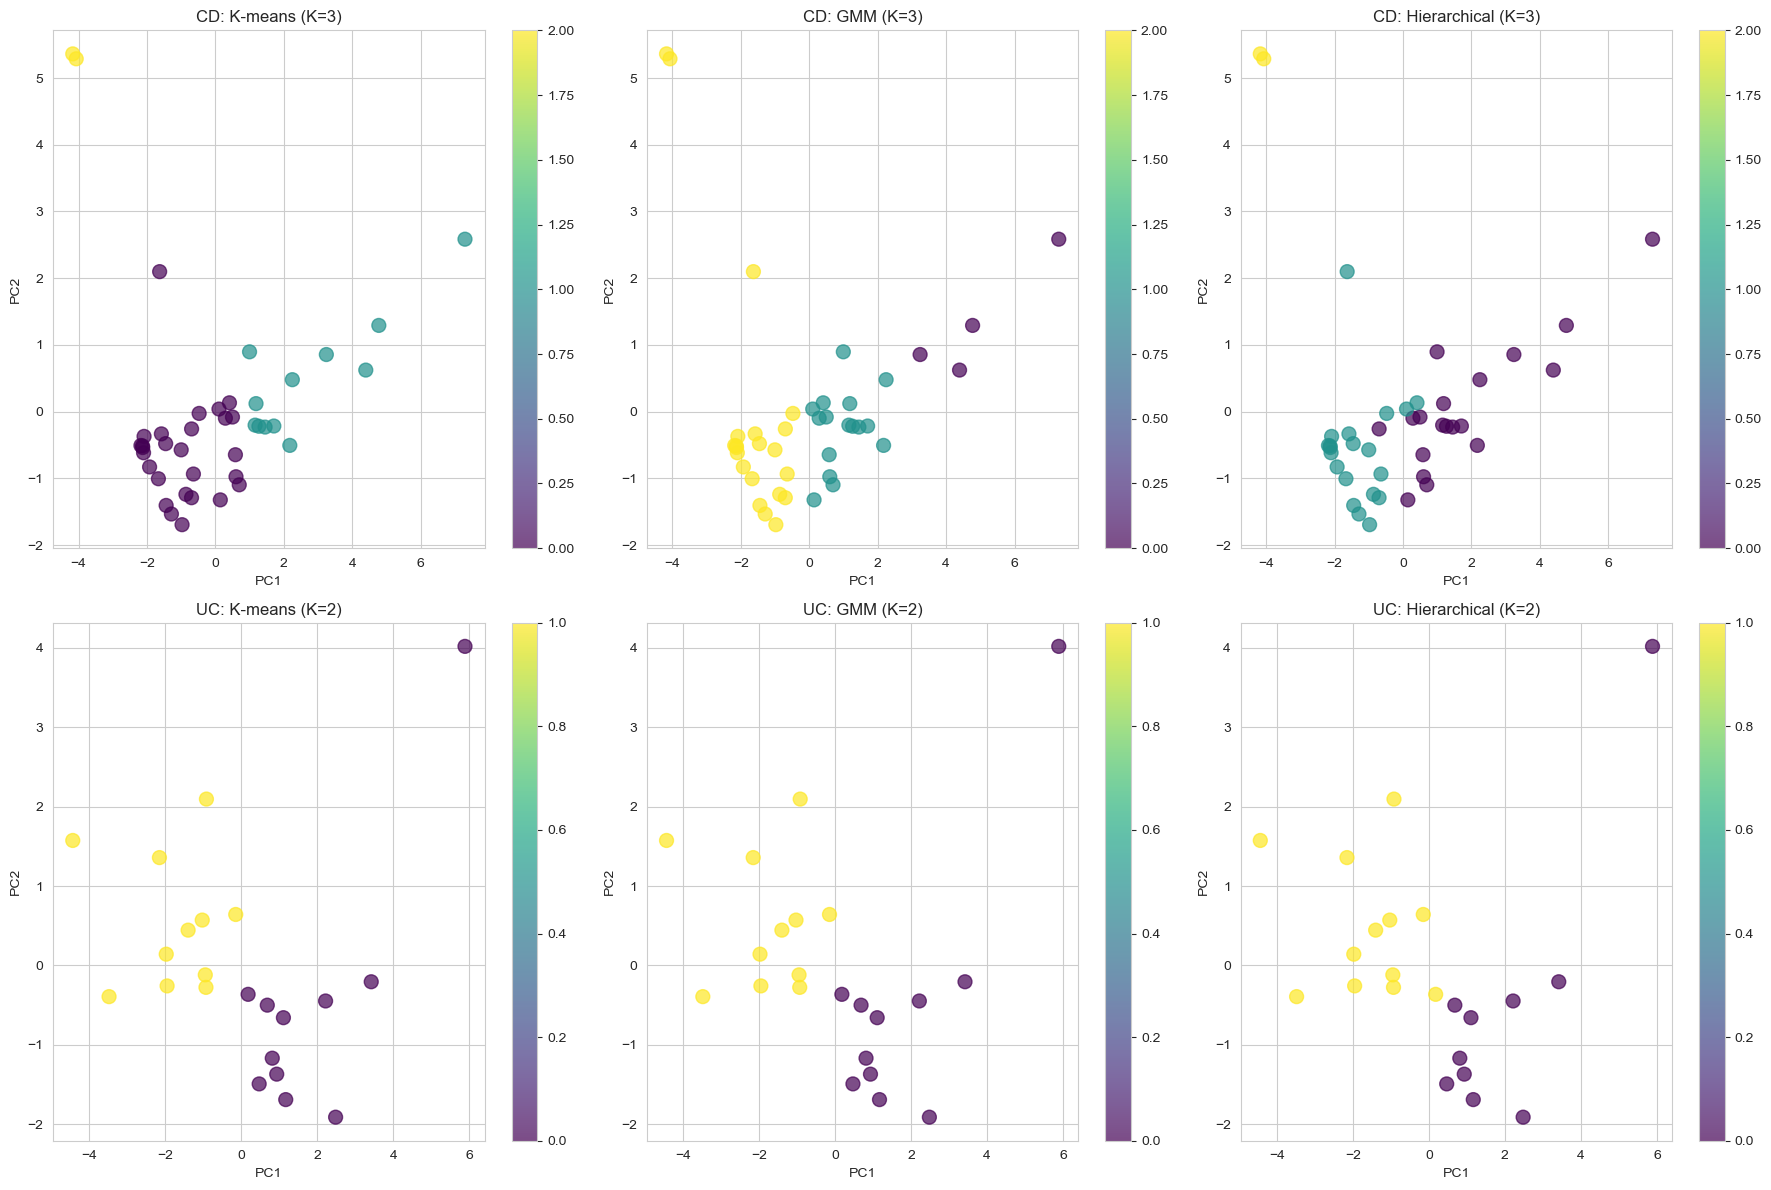

In [8]:
pca_viz = PCA(n_components=2, random_state=42)

cd_pca = pca_viz.fit_transform(cd_features_scaled)
uc_pca = pca_viz.fit_transform(uc_features_scaled)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# CD visualizations
for idx, (labels, method) in enumerate([
    (cd_labels_km, 'K-means'),
    (cd_labels_gmm, 'GMM'),
    (cd_labels_hier, 'Hierarchical')
]):
    ax = axes[0, idx]
    scatter = ax.scatter(cd_pca[:, 0], cd_pca[:, 1], c=labels, cmap='viridis', s=100, alpha=0.7)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(f'CD: {method} (K={K_CD})')
    plt.colorbar(scatter, ax=ax)

# UC visualizations
for idx, (labels, method) in enumerate([
    (uc_labels_km, 'K-means'),
    (uc_labels_gmm, 'GMM'),
    (uc_labels_hier, 'Hierarchical')
]):
    ax = axes[1, idx]
    scatter = ax.scatter(uc_pca[:, 0], uc_pca[:, 1], c=labels, cmap='viridis', s=100, alpha=0.7)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(f'UC: {method} (K={K_UC})')
    plt.colorbar(scatter, ax=ax)

plt.tight_layout()
plt.savefig('../results/dual_encoder_model/cluster_visualization.png', dpi=150)
plt.show()